In [1]:
pip install webdriver-manager

Note: you may need to restart the kernel to use updated packages.


#### Scraping Data

In [2]:
import time
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service 
from webdriver_manager.chrome import ChromeDriverManager 
from datetime import datetime

BASE_DOMAIN = "https://www.banggood.com"


def log_progress(message):
    """Logs message with timestamp to console and file."""
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(f"[{timestamp}] {message}")
    try:
        with open('code_log.txt', 'a') as f:
            f.write(f"[{timestamp}] {message}\n")
    except: pass

def get_category_data(category, url):
    log_progress(f"Starting scrape for: {category} on {url}")

    try:
        driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    except Exception as e:
        log_progress(f"Failed to initialize Chrome driver: {e}")
        return pd.DataFrame()
        
    data = []
    
    try:
        driver.get(url)
        time.sleep(3) 
       
        for i in range(1, 6):
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(1.5)
            
        soup = BeautifulSoup(driver.page_source, "html.parser")
        
        cards = soup.select(".product-item") or soup.select(".p-wrap")
        log_progress(f"Found {len(cards)} items in {category}")
        
        for c in cards:
            try:
                link = c.select_one("a")
                name = link.get("title") or c.select_one("img").get("alt") if link and c.select_one("img") else 'N/A'
                price = c.select_one(".price, .price-box").get_text(strip=True) if c.select_one(".price, .price-box") else 'N/A'
                
                if name != 'N/A':
                    p_url = link.get("href", "") if link else ""
                    if p_url and not p_url.startswith("http"):  
                        p_url = BASE_DOMAIN + p_url
                        
                    rating = c.select_one(".review-text") 
                    reviews = c.select_one(".review")
                    
                    data.append({
                        "Category": category,
                        "Name": name,
                        "Price": price,
                        "Rating": rating.get_text(strip=True) if rating else 'N/A', 
                        "Reviews": reviews.get_text(strip=True).replace('(', '').replace(')', '').split()[0] if reviews else '0', 
                        "URL": p_url
                    })
            except Exception as e: 
                # print(f"Product parsing error: {e}")
                continue 
            
        return pd.DataFrame(data)
        
    except Exception as e:
        log_progress(f"Error during page access/parsing for {category}: {e}")
        return pd.DataFrame()
        
    finally:
        # Ensures the browser window closes even if errors occur
        try:
            driver.quit()
        except:
            pass 

if __name__ == "__main__":
    categories = {
        "Camping": "https://www.banggood.com/Wholesale-Camping-ca-6030.html",
        "Outdoor-Lighting": "https://www.banggood.com/Wholesale-Outdoor-Lighting-ca-14029.html",
        "Computers": "https://www.banggood.com/Wholesale-Computers-and-Office-ca-2002.html",
        "Networking": "https://www.banggood.com/Wholesale-Networking-ca-5061.html",
        "Commercial-Lighting": "https://www.banggood.com/Wholesale-Commercial-Lighting-ca-14124.html"
    }

    log_progress("Batch extraction started with NEW categories...")

    all_dfs = [get_category_data(cat, url) for cat, url in categories.items()]

    valid_dfs = [df for df in all_dfs if not df.empty]
    
    if valid_dfs:
        final_df = pd.concat(valid_dfs, ignore_index=True)
        final_df.to_csv("banggood_data.csv", index=False)
        
        log_progress(f"Data saved with {len(final_df)} total items.")
        print(final_df['Category'].value_counts())
    else:
        log_progress("No data extracted.")

[2025-11-24 15:13:27] Batch extraction started with NEW categories...
[2025-11-24 15:13:27] Starting scrape for: Camping on https://www.banggood.com/Wholesale-Camping-ca-6030.html
[2025-11-24 15:13:46] Found 60 items in Camping
[2025-11-24 15:13:48] Starting scrape for: Outdoor-Lighting on https://www.banggood.com/Wholesale-Outdoor-Lighting-ca-14029.html
[2025-11-24 15:14:11] Found 60 items in Outdoor-Lighting
[2025-11-24 15:14:13] Starting scrape for: Computers on https://www.banggood.com/Wholesale-Computers-and-Office-ca-2002.html
[2025-11-24 15:14:32] Found 60 items in Computers
[2025-11-24 15:14:35] Starting scrape for: Networking on https://www.banggood.com/Wholesale-Networking-ca-5061.html
[2025-11-24 15:14:53] Found 45 items in Networking
[2025-11-24 15:14:55] Starting scrape for: Commercial-Lighting on https://www.banggood.com/Wholesale-Commercial-Lighting-ca-14124.html
[2025-11-24 15:15:15] Found 4 items in Commercial-Lighting
[2025-11-24 15:15:17] Data saved with 229 total it

#### Cleaning Csv

In [3]:
import pandas as pd

df = pd.read_csv("banggood_data.csv")
print("Initial rows:", len(df))

df['Price_Clean'] = (
    df['Price']
    .str.replace('£', '', regex=False)
    .str.replace(',', '', regex=False)
    .str.extract(r"(\d+\.?\d*)")[0]
    .astype(float)
)

df['Rating_Clean'] = pd.to_numeric(df['Rating'], errors='coerce').fillna(0)

df['Reviews_Clean'] = pd.to_numeric(df['Reviews'], errors='coerce').fillna(0).astype(int)

df['Price_Level'] = pd.cut(
    df['Price_Clean'],
    bins=[0, 10, 20, 40, 80, 200, 10000],
    labels=['Very Low', 'Low', 'Mid', 'High', 'Premium', 'Luxury']
)

df['Rating_Category'] = pd.cut(
    df['Rating_Clean'],
    bins=[0, 2, 3.5, 4.5, 5.1],
    labels=['Poor', 'Average', 'Good', 'Excellent']
)

df['Popularity_Score'] = df['Rating_Clean'] * df['Reviews_Clean']

df.to_csv("banggood_cleaned.csv", index=False)

print("Cleaned file saved as banggood_cleaned.csv")
df.head()


Initial rows: 229
Cleaned file saved as banggood_cleaned.csv


,Category,Name,Price,Rating,Reviews,URL,Price_Clean,Rating_Clean,Reviews_Clean,Price_Level,Rating_Category,Popularity_Score
0,Camping,1000W Solar Panel 12V Solar Cell 20A Controlle...,US$30.87,NaN,0,https://www.banggood.com/1000W-Solar-Panel-12V...,30.87,0.00,0,Mid,NaN,0.00
1,Camping,12V/24V MPPT Solar Charge Controller Regulator...,US$15.51,5.00,2,https://www.banggood.com/12V-or-24V-MPPT-Solar...,15.51,5.00,2,Low,Excellent,10.00
2,Camping,SMILING SHARK Multifunctional Portable Adjusta...,US$9.59,4.00,1,https://www.banggood.com/SMILING-SHARK-Multifu...,9.59,4.00,1,Very Low,Good,4.00
3,Camping,6 Blade Wood Burner Fireplace Fan Mini Heat Po...,US$29.99,NaN,0,https://www.banggood.com/6-Blade-Wood-Burner-F...,29.99,0.00,0,Mid,NaN,0.00
4,Camping,Portable Hand Crank Generator Reliable Emergen...,US$35.89,4.94,18,https://www.banggood.com/Portable-Hand-Crank-G...,35.89,4.94,18,Mid,Excellent,88.92


#### Making Plots and Analyzing

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("banggood_cleaned.csv")

sns.set(style="whitegrid")

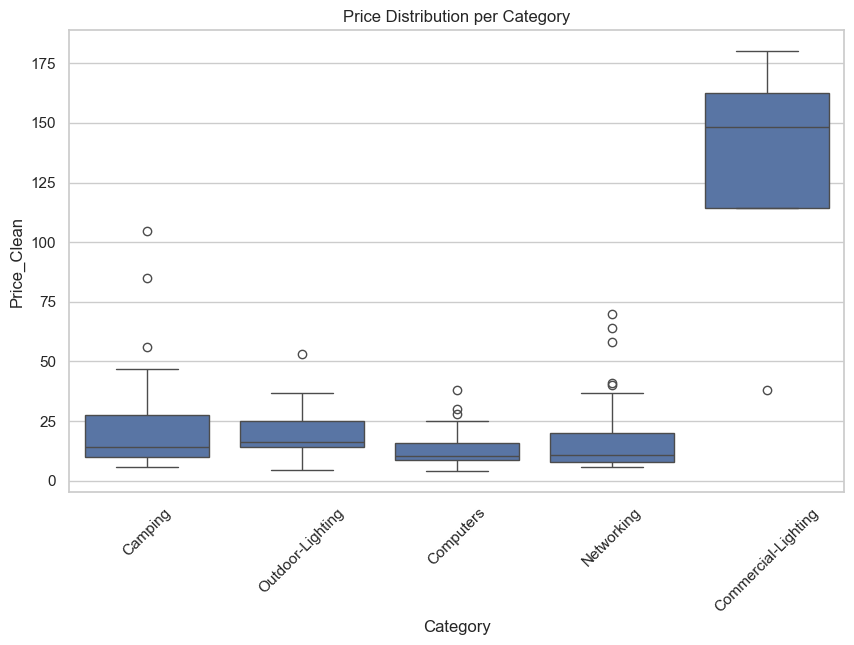

In [5]:
##Analysis 1: Price Distribution per Category
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="Category", y="Price_Clean")
plt.title("Price Distribution per Category")
plt.xticks(rotation=45)

plt.show()

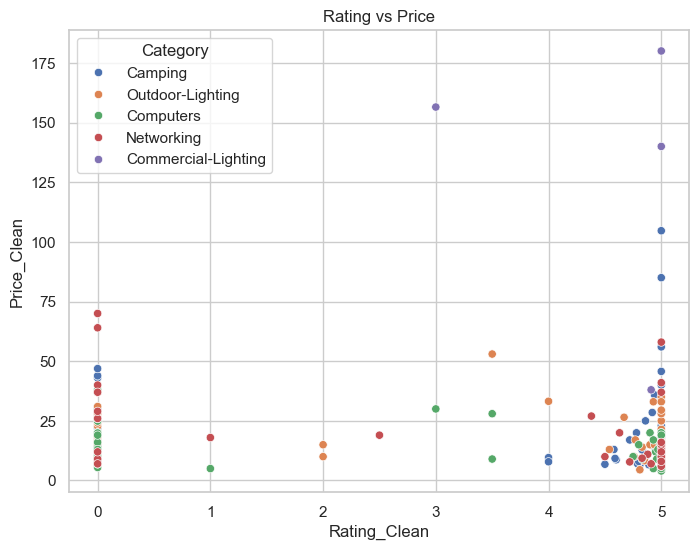

Correlation between price and rating: -0.041870169805687044


In [6]:
#Analysis 2: Rating vs Price Correlation
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="Rating_Clean", y="Price_Clean", hue="Category")
plt.title("Rating vs Price")

plt.show()

correlation = df['Rating_Clean'].corr(df['Price_Clean'])
print("Correlation between price and rating:", correlation)


C:\Users\user\AppData\Local\Temp\ipykernel_6596\4121406598.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\user\AppData\Local\Temp\ipykernel_6596\4121406598.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


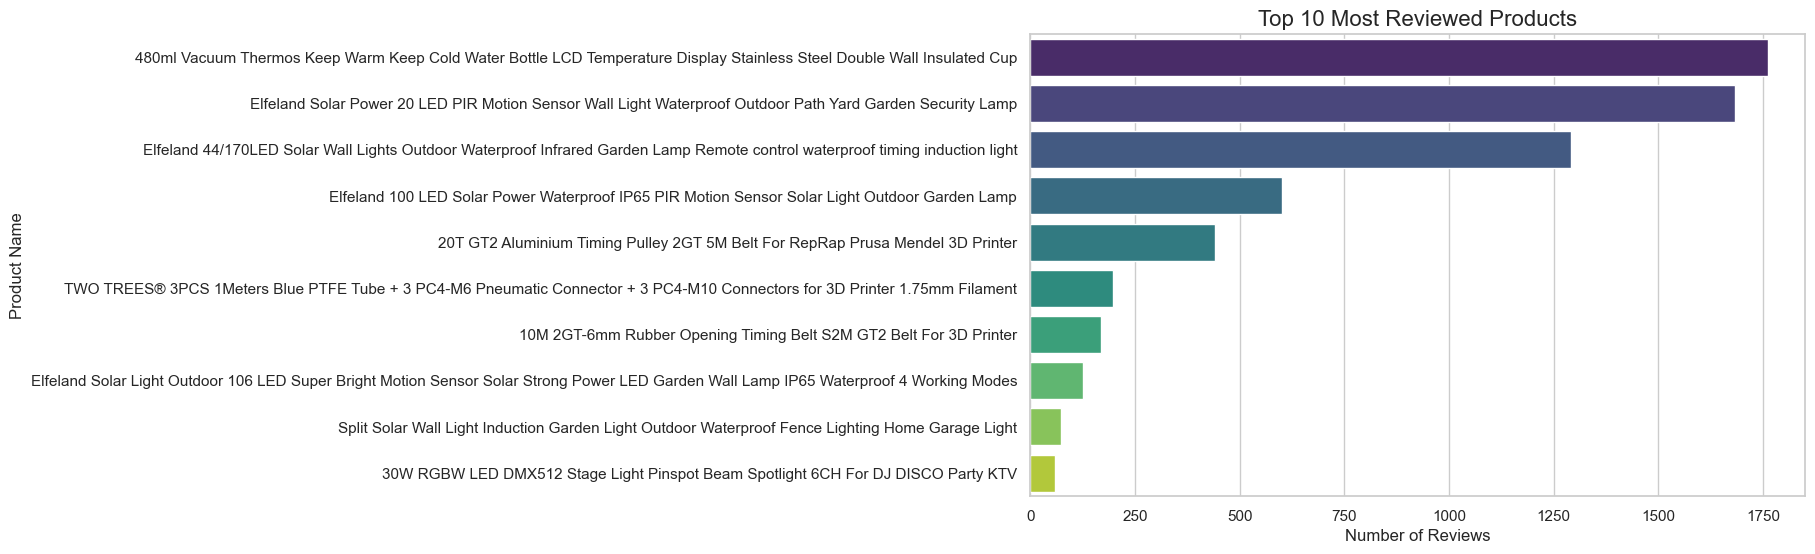

In [7]:
# Analysis 3: Top Reviewed Products
TOP_N = 10

# Filter out rows with missing Name and sort by Reviews_Clean
top_reviewed_products = df.dropna(subset=['Name']).sort_values(
    by='Reviews_Clean',
    ascending=False
).head(TOP_N)

# Set up the plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Reviews_Clean',
    y='Name',
    data=top_reviewed_products,
    palette='viridis'
)

# Add labels and title
plt.title(f'Top {TOP_N} Most Reviewed Products', fontsize=16)
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Product Name', fontsize=12)

# Ensure layout is tight
plt.tight_layout()

# Save the plot
plt.savefig('top_reviewed_products_bar.png')
#plt.close()

plt.show()

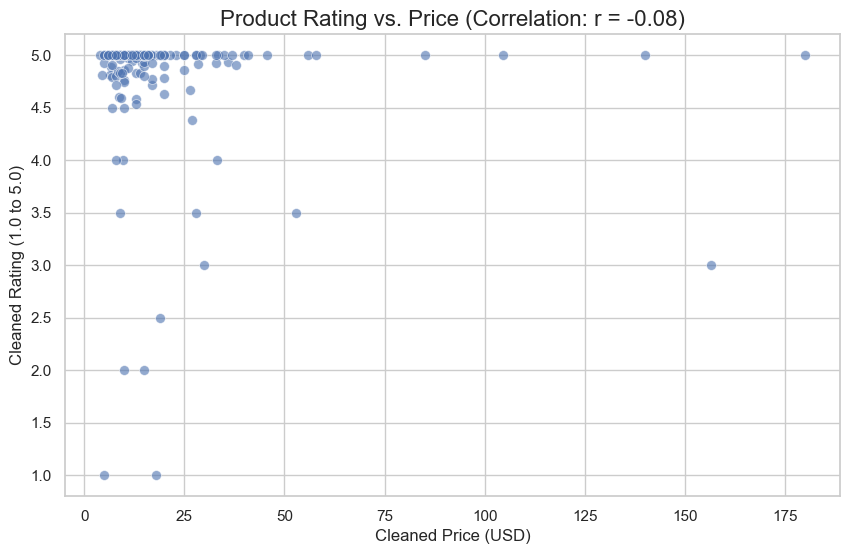

In [8]:
# Analysis 4: “Best Value” Metric per Category
df_scatter = df[(df['Price_Clean'] > 0) & (df['Rating_Clean'] > 0)].copy()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Price_Clean',
    y='Rating_Clean',
    data=df_scatter,
    alpha=0.6,
    s=50 # Point size
)

# Calculate the Pearson correlation coefficient
correlation = df_scatter['Price_Clean'].corr(df_scatter['Rating_Clean'])

# Add labels and title
plt.title(f'Product Rating vs. Price (Correlation: r = {correlation:.2f})', fontsize=16)
plt.xlabel('Cleaned Price (USD)', fontsize=12)
plt.ylabel('Cleaned Rating (1.0 to 5.0)', fontsize=12)

# Save the plot
plt.savefig('rating_vs_price_correlation.png')
# plt.close()

plt.show()

Stock_Flag
Likely In Stock       154
Possibly Low Stock     75
Name: count, dtype: int64


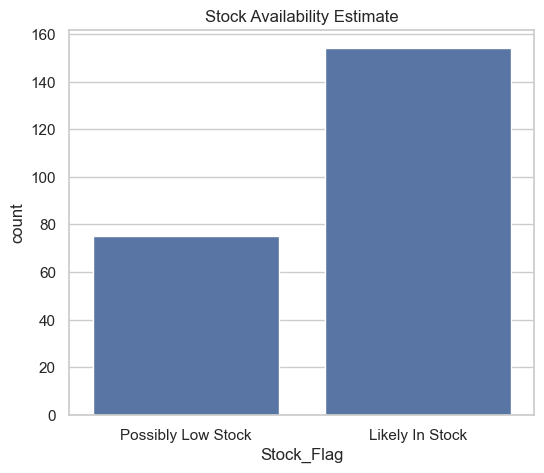

In [9]:
#Analysis 5: Stock Availability Analysis
df['Stock_Flag'] = df['Reviews_Clean'].apply(lambda x: 'Likely In Stock' if x > 0 else 'Possibly Low Stock')

stock_summary = df['Stock_Flag'].value_counts()
print(stock_summary)

plt.figure(figsize=(6,5))
sns.countplot(data=df, x='Stock_Flag')
plt.title("Stock Availability Estimate")
plt.show()


#### Connecting to Sql

In [16]:
import pyodbc
import pandas as pd
import numpy as np

df = pd.read_csv("./banggood_cleaned.csv")
print(f"Loaded {len(df)} rows from CSV")

df['Price_Clean'] = pd.to_numeric(df['Price_Clean'], errors='coerce')
df['Rating_Clean'] = pd.to_numeric(df['Rating_Clean'], errors='coerce')
df['Reviews_Clean'] = pd.to_numeric(df['Reviews_Clean'], errors='coerce')
df['Popularity_Score'] = pd.to_numeric(df['Popularity_Score'], errors='coerce')

df['Price_Clean'] = df['Price_Clean'].round(2)
df['Popularity_Score'] = df['Popularity_Score'].round(2)

df['Name'] = df['Name'].fillna('Unknown Product')

df = df.where(pd.notnull(df), None)

print("\n--- Data Validation Check ---")
print(f"Price_Clean - Min: {df['Price_Clean'].min()}, Max: {df['Price_Clean'].max()}")
print(f"Rating_Clean - Min: {df['Rating_Clean'].min()}, Max: {df['Rating_Clean'].max()}")
print(f"Null counts:")
print(df[['Price_Clean', 'Rating_Clean', 'Reviews_Clean', 'Popularity_Score']].isnull().sum())

problematic_rows = df[df['Price_Clean'].apply(lambda x: x is not None and (not isinstance(x, (int, float)) or np.isinf(x)))]
if len(problematic_rows) > 0:
    print(f"\n WARNING: Found {len(problematic_rows)} problematic Price_Clean rows:")
    print(problematic_rows[['Name', 'Price_Clean']].head())

server = r"DESKTOP-J5A8O7S\user" 
database = "BanggoodDB"  
conn_str = (
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=DESKTOP-J5A8O7S;"
    "Database=BanggoodDB;"
    "Trusted_Connection=yes;"
)

print("\n--- Attempting to connect to SQL Server ---")
try:
    conn = pyodbc.connect(conn_str)
    cursor = conn.cursor()
    print(" Connected Successfully!")
    
    cursor.execute("""
    IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='Products' AND xtype='U')
    CREATE TABLE Products (
        id INT IDENTITY(1,1) PRIMARY KEY,
        Category NVARCHAR(100),
        Name NVARCHAR(MAX),
        Price NVARCHAR(50),
        Rating NVARCHAR(50),
        Reviews NVARCHAR(50),
        URL NVARCHAR(MAX),
        Price_Clean DECIMAL(18, 2),
        Rating_Clean FLOAT,
        Reviews_Clean INT,
        Price_Level NVARCHAR(50),
        Rating_Category NVARCHAR(50),
        Popularity_Score DECIMAL(18, 2)
    );
    """)
    conn.commit()
    print(" Table 'Products' ensured.")
    
    insert_count = 0
    error_count = 0
    
    for index, row in df.iterrows():
        try:
            cursor.execute("""
            INSERT INTO Products (Category, Name, Price, Rating, Reviews, URL, 
                                Price_Clean, Rating_Clean, Reviews_Clean, 
                                Price_Level, Rating_Category, Popularity_Score)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
            """, 
            row["Category"], 
            row["Name"], 
            row["Price"],  # Keep as string
            str(row["Rating"]) if row["Rating"] is not None else None,
            str(row["Reviews"]) if row["Reviews"] is not None else None,
            row["URL"], 
            row["Price_Clean"], 
            row["Rating_Clean"], 
            row["Reviews_Clean"], 
            row["Price_Level"], 
            row["Rating_Category"], 
            row["Popularity_Score"])
            
            insert_count += 1
            
        except Exception as row_error:
            error_count += 1
            print(f"\n Error on row {index}: {row_error}")
            print(f"   Problematic data: Price_Clean={row['Price_Clean']}, Rating_Clean={row['Rating_Clean']}")
            if error_count >= 5:  # Stop after 5 errors to avoid spam
                print("Too many errors, stopping...")
                break
    
    conn.commit()
    print(f"\nData Inserted Successfully! {insert_count} rows committed.")
    if error_count > 0:
        print(f"{error_count} rows failed to insert.")
        
except Exception as e:
    print("\n Error:", e)
    print("\nTroubleshooting steps:")
    print("1. Check if Price_Clean column has values exceeding DECIMAL(18,2) range")
    print("2. Verify all numeric columns are properly cleaned")
    print("3. Try manually inspecting the first few rows of your CSV")
    
finally:
    try:
        conn.close()
        print("\n Connection Closed.")
    except:
        pass


Loaded 229 rows from CSV

--- Data Validation Check ---
Price_Clean - Min: 3.99, Max: 179.99
Rating_Clean - Min: 0.0, Max: 5.0
Null counts:
Price_Clean         0
Rating_Clean        0
Reviews_Clean       0
Popularity_Score    0
dtype: int64

--- Attempting to connect to SQL Server ---
 Connected Successfully!
 Table 'Products' ensured.

Data Inserted Successfully! 229 rows committed.

 Connection Closed.
